In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import NuestrasFunciones

In [2]:
df_titanic = pd.read_csv("In/train.csv")

In [3]:
df_titanic.rename(columns = {"SibSp": "SiblingsSpouses","Parch":"ParentsChildren"},inplace = True)

In [4]:
df_titanic.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [5]:
def contar_valores(df,max_valores = 5):
    for i in df.columns:
        if df[i].nunique() < max_valores:
            print(f"value counts de {df[i].name} es:")
            print(df[i].value_counts(dropna= False))
            print("--------------------------------")

In [6]:
contar_valores(df_titanic,max_valores = 20)

value counts de Survived es:
0    549
1    342
Name: Survived, dtype: int64
--------------------------------
value counts de Pclass es:
3    491
1    216
2    184
Name: Pclass, dtype: int64
--------------------------------
value counts de Sex es:
male      577
female    314
Name: Sex, dtype: int64
--------------------------------
value counts de SiblingsSpouses es:
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SiblingsSpouses, dtype: int64
--------------------------------
value counts de ParentsChildren es:
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: ParentsChildren, dtype: int64
--------------------------------
value counts de Embarked es:
S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64
--------------------------------


### Bajo age, ParentsChildren = 0 significa niño solo.

Cont


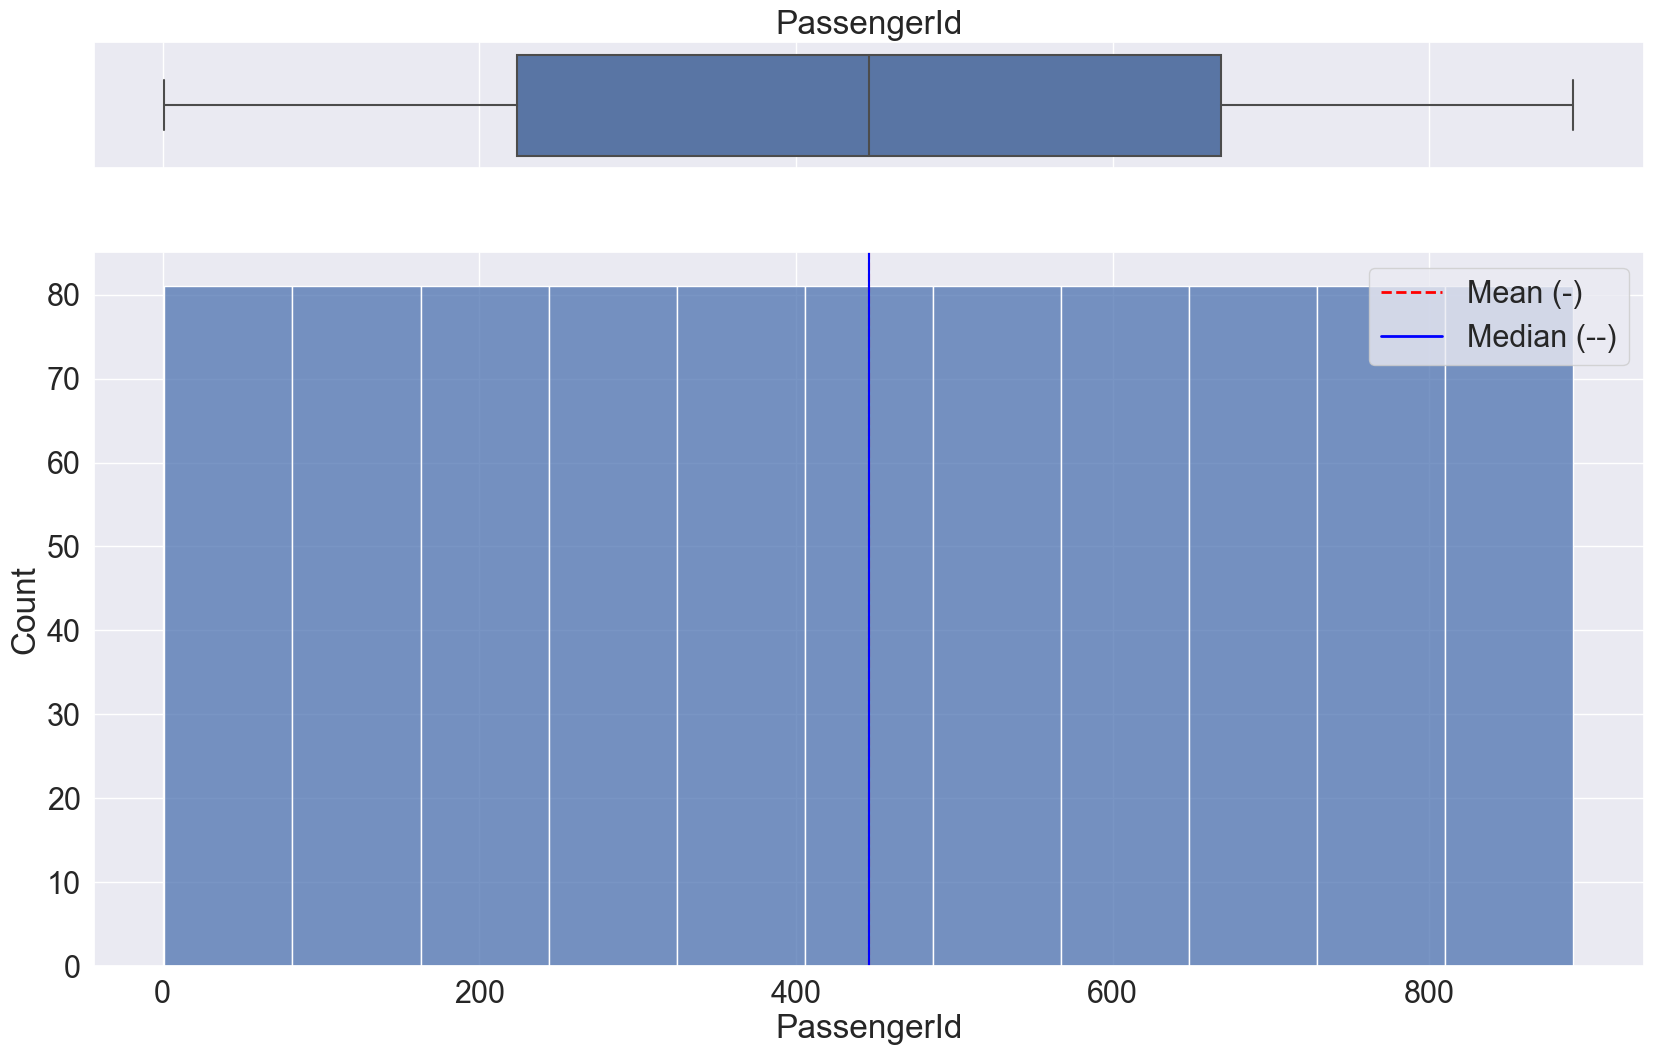

Cont


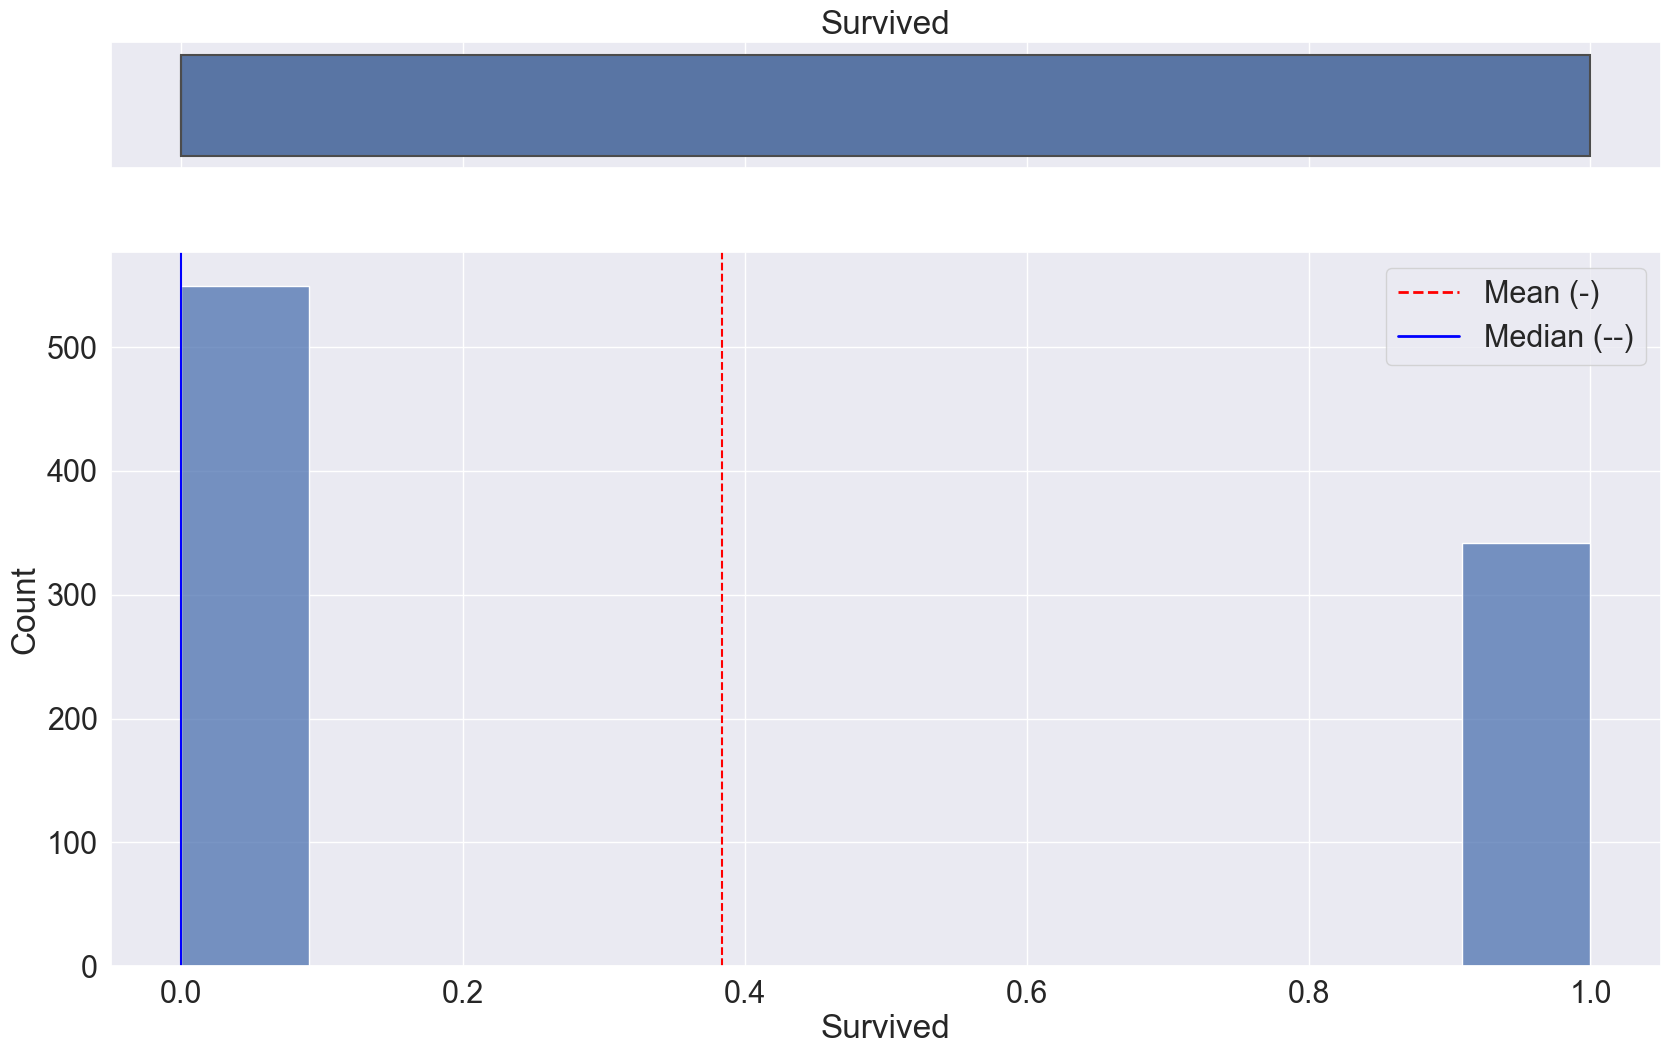

Cont


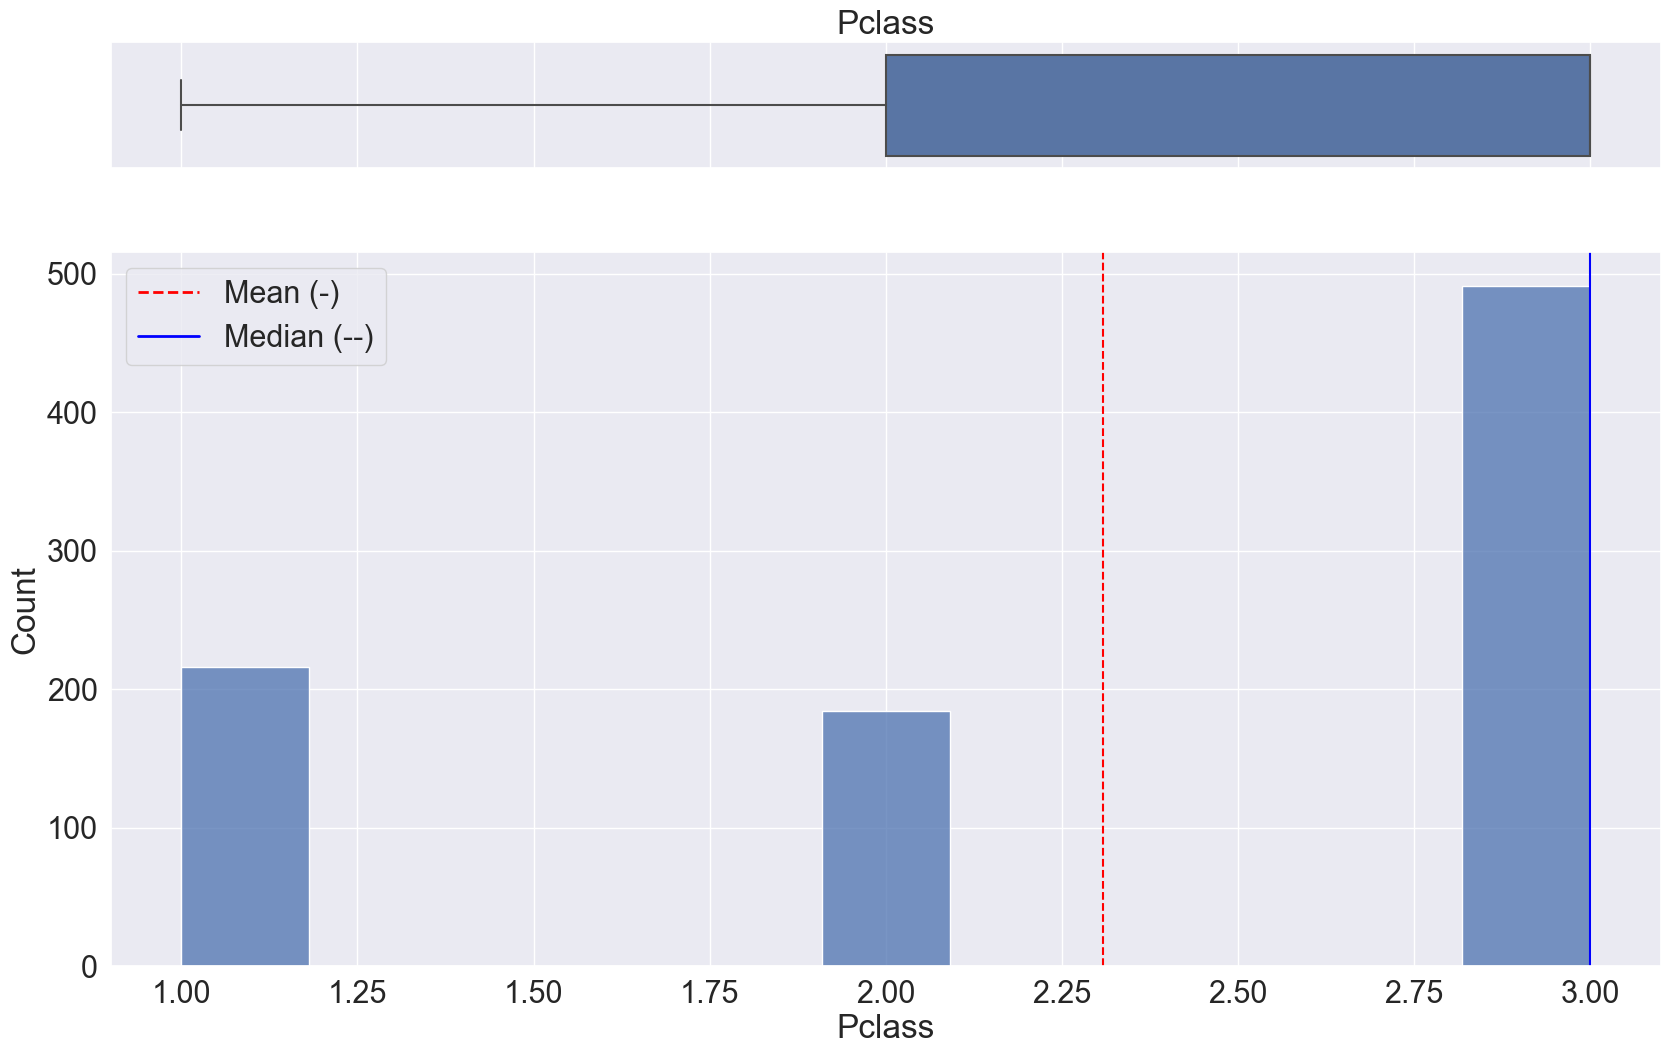

Change column: Name to another data type
Change column: Sex to another data type
Cont


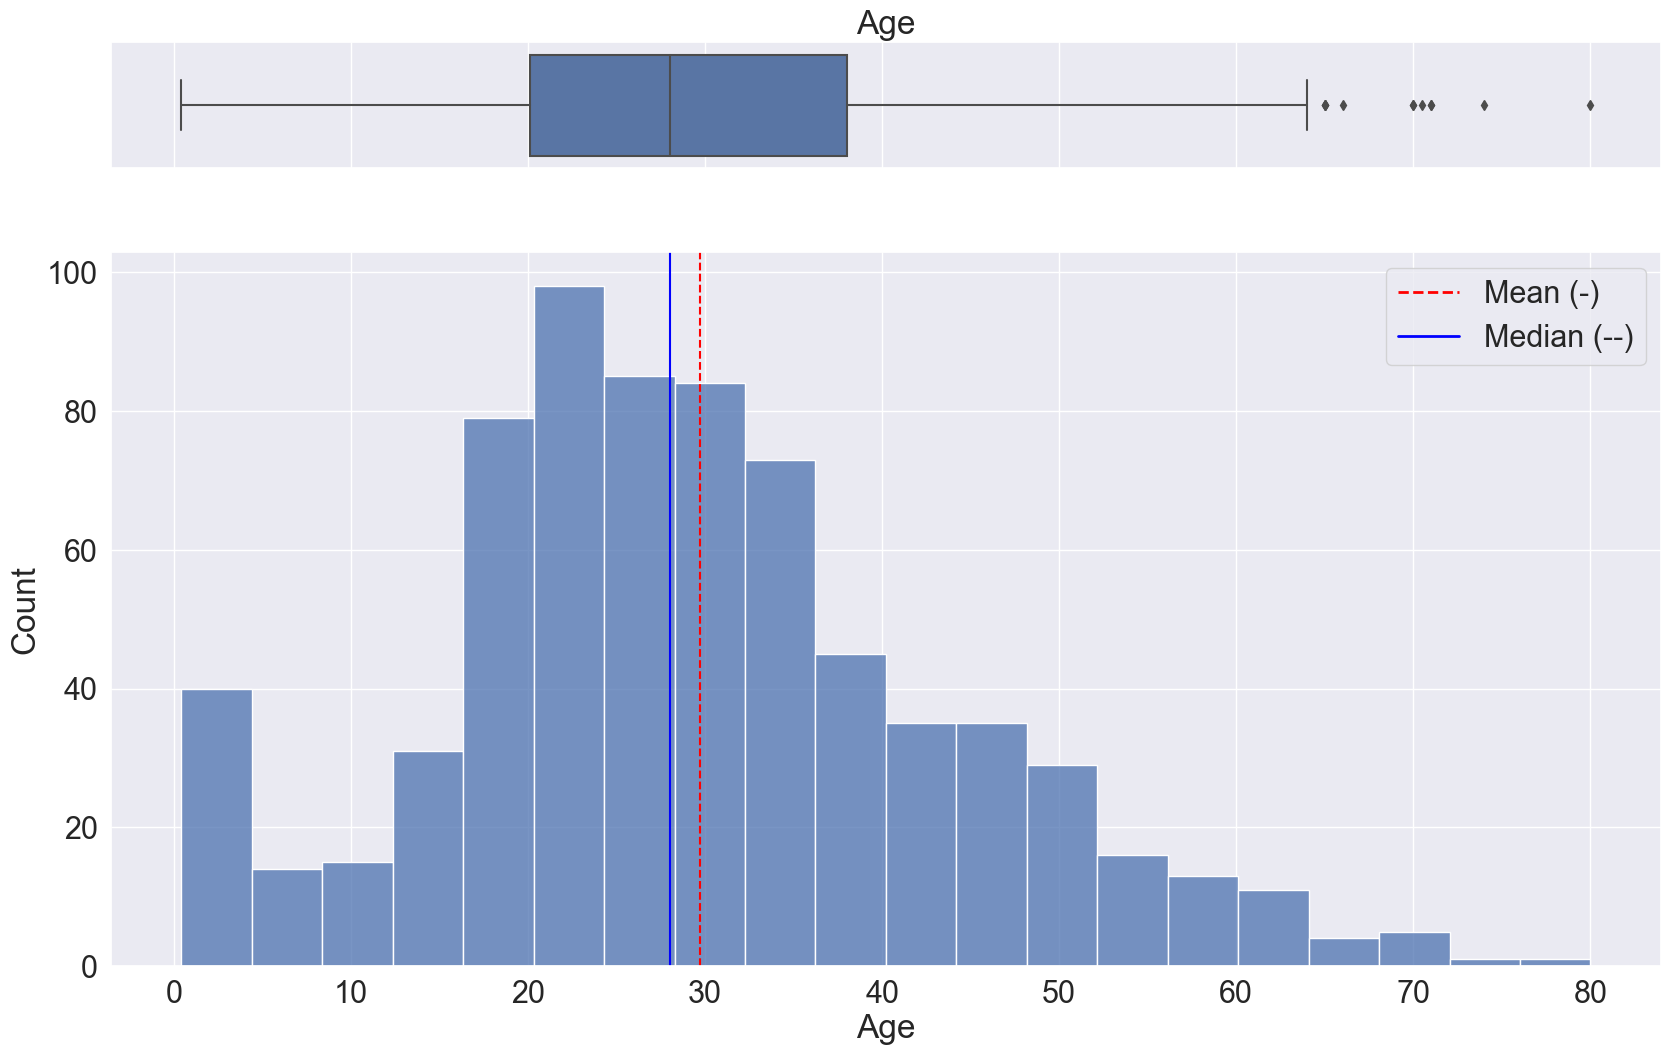

Cont


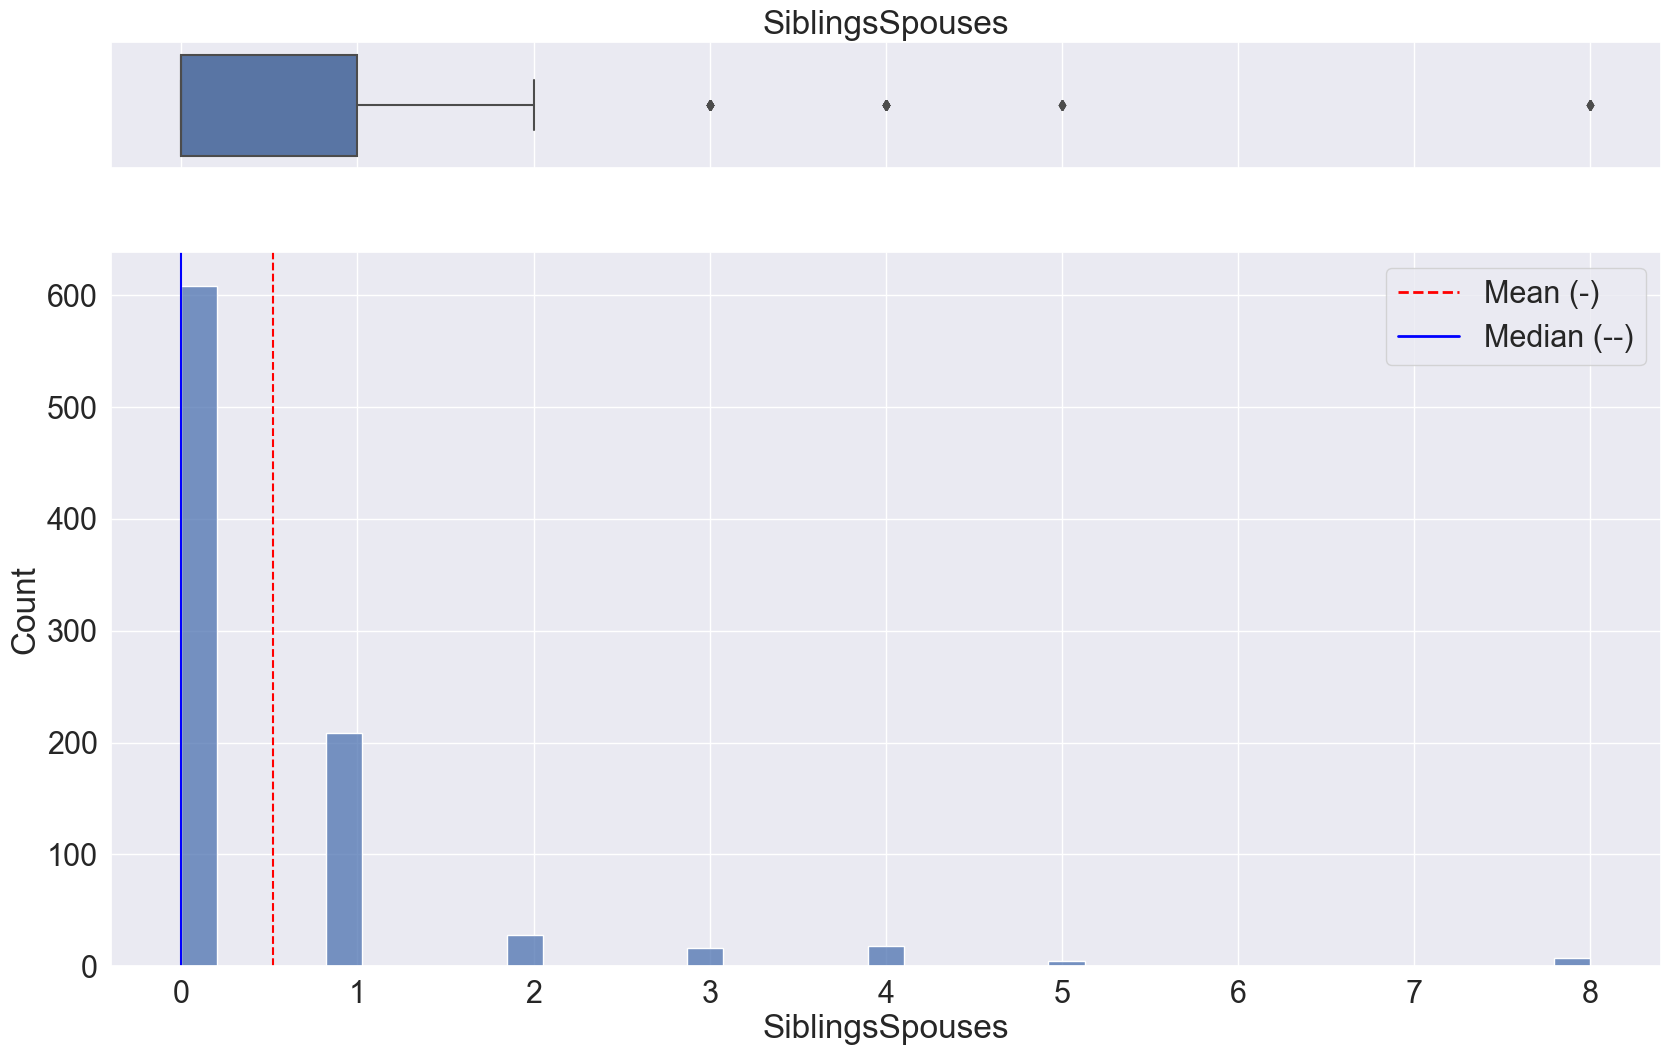

Cont


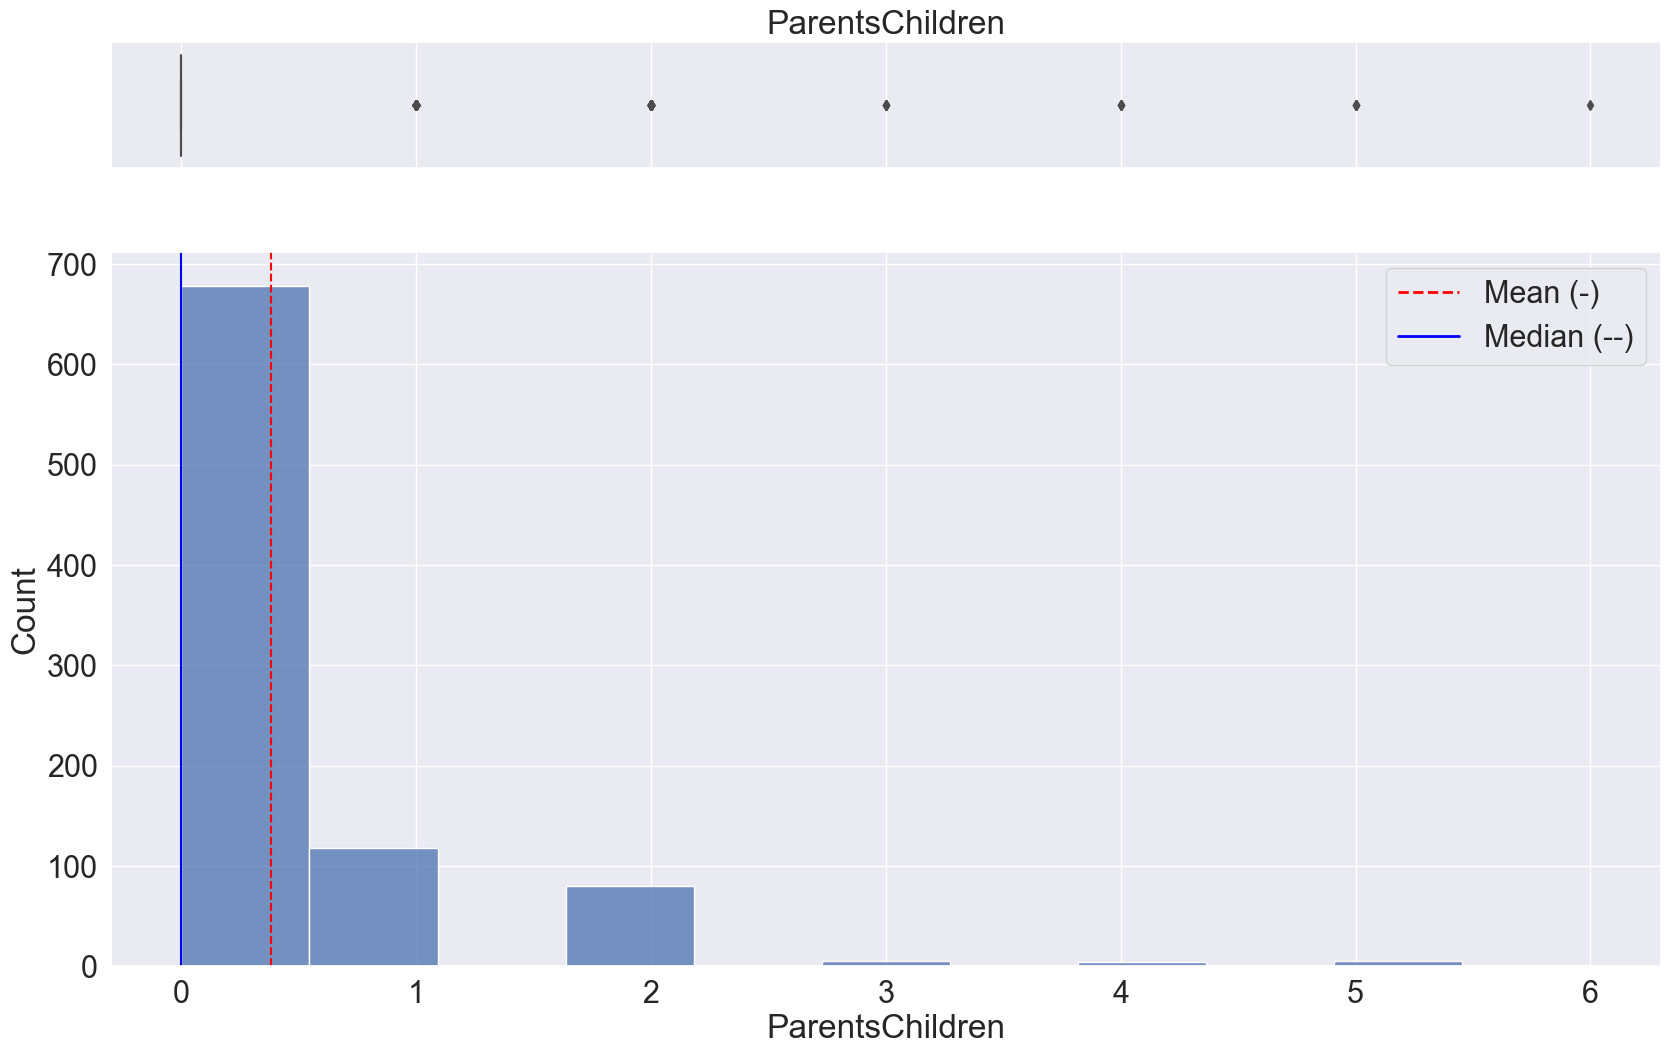

Change column: Ticket to another data type
Cont


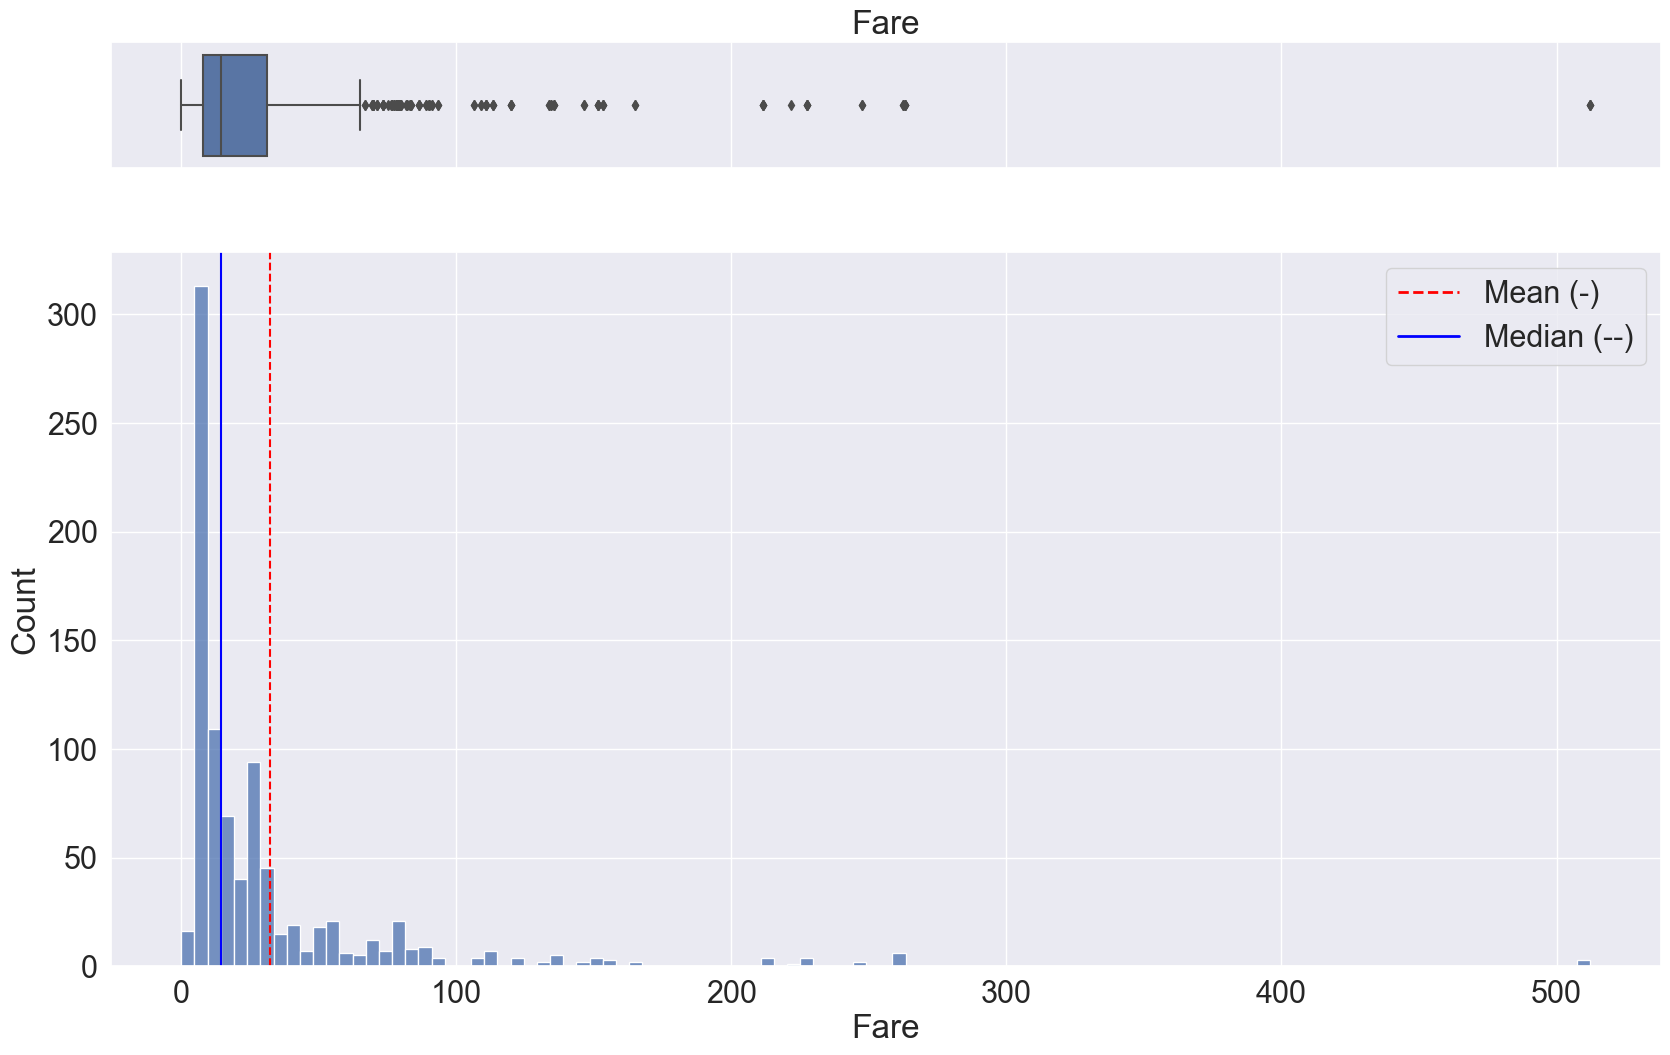

Change column: Cabin to another data type
Change column: Embarked to another data type


PassengerId        None
Survived           None
Pclass             None
Name               None
Sex                None
Age                None
SiblingsSpouses    None
ParentsChildren    None
Ticket             None
Fare               None
Cabin              None
Embarked           None
dtype: object

In [7]:
#df_titanic.drop(["Name","Sex","Ticket","Cabin","Embarked"],axis=1).apply(NuestrasFunciones.plot)
df_titanic.apply(NuestrasFunciones.plot)

In [8]:
df_titanic.apply(lambda x: x.isna().sum())

PassengerId          0
Survived             0
Pclass               0
Name                 0
Sex                  0
Age                177
SiblingsSpouses      0
ParentsChildren      0
Ticket               0
Fare                 0
Cabin              687
Embarked             2
dtype: int64

In [9]:
df_titanic.Cabin.describe()

count         204
unique        147
top       B96 B98
freq            4
Name: Cabin, dtype: object

### Personas con misma cabin puede dar juego, especialmente porque instrucciones dicen algo de mistresses.

### Las NA se deben poder conseguir en apellidos!

In [10]:
df_titanic.Age.describe()
#Puede que valga la pena tramificar
#Se debe poder sacar el NA con SiblingsSpouse y apellido!! Ambas columnas sin NA

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [11]:
df_titanic.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age',
       'SiblingsSpouses', 'ParentsChildren', 'Ticket', 'Fare', 'Cabin',
       'Embarked'],
      dtype='object')

# Se cambia sex a dicotómica 1=male ; 0=female 

In [12]:
df_titanic.Sex

0        male
1      female
2      female
3      female
4        male
        ...  
886      male
887    female
888    female
889      male
890      male
Name: Sex, Length: 891, dtype: object

In [13]:
df_titanic.loc[df_titanic["Sex"] == "male", "Sex"] = 1
df_titanic.loc[df_titanic["Sex"] == "female", "Sex"] = 0
df_titanic["Sex"] = df_titanic["Sex"].astype("category")

<Axes: >

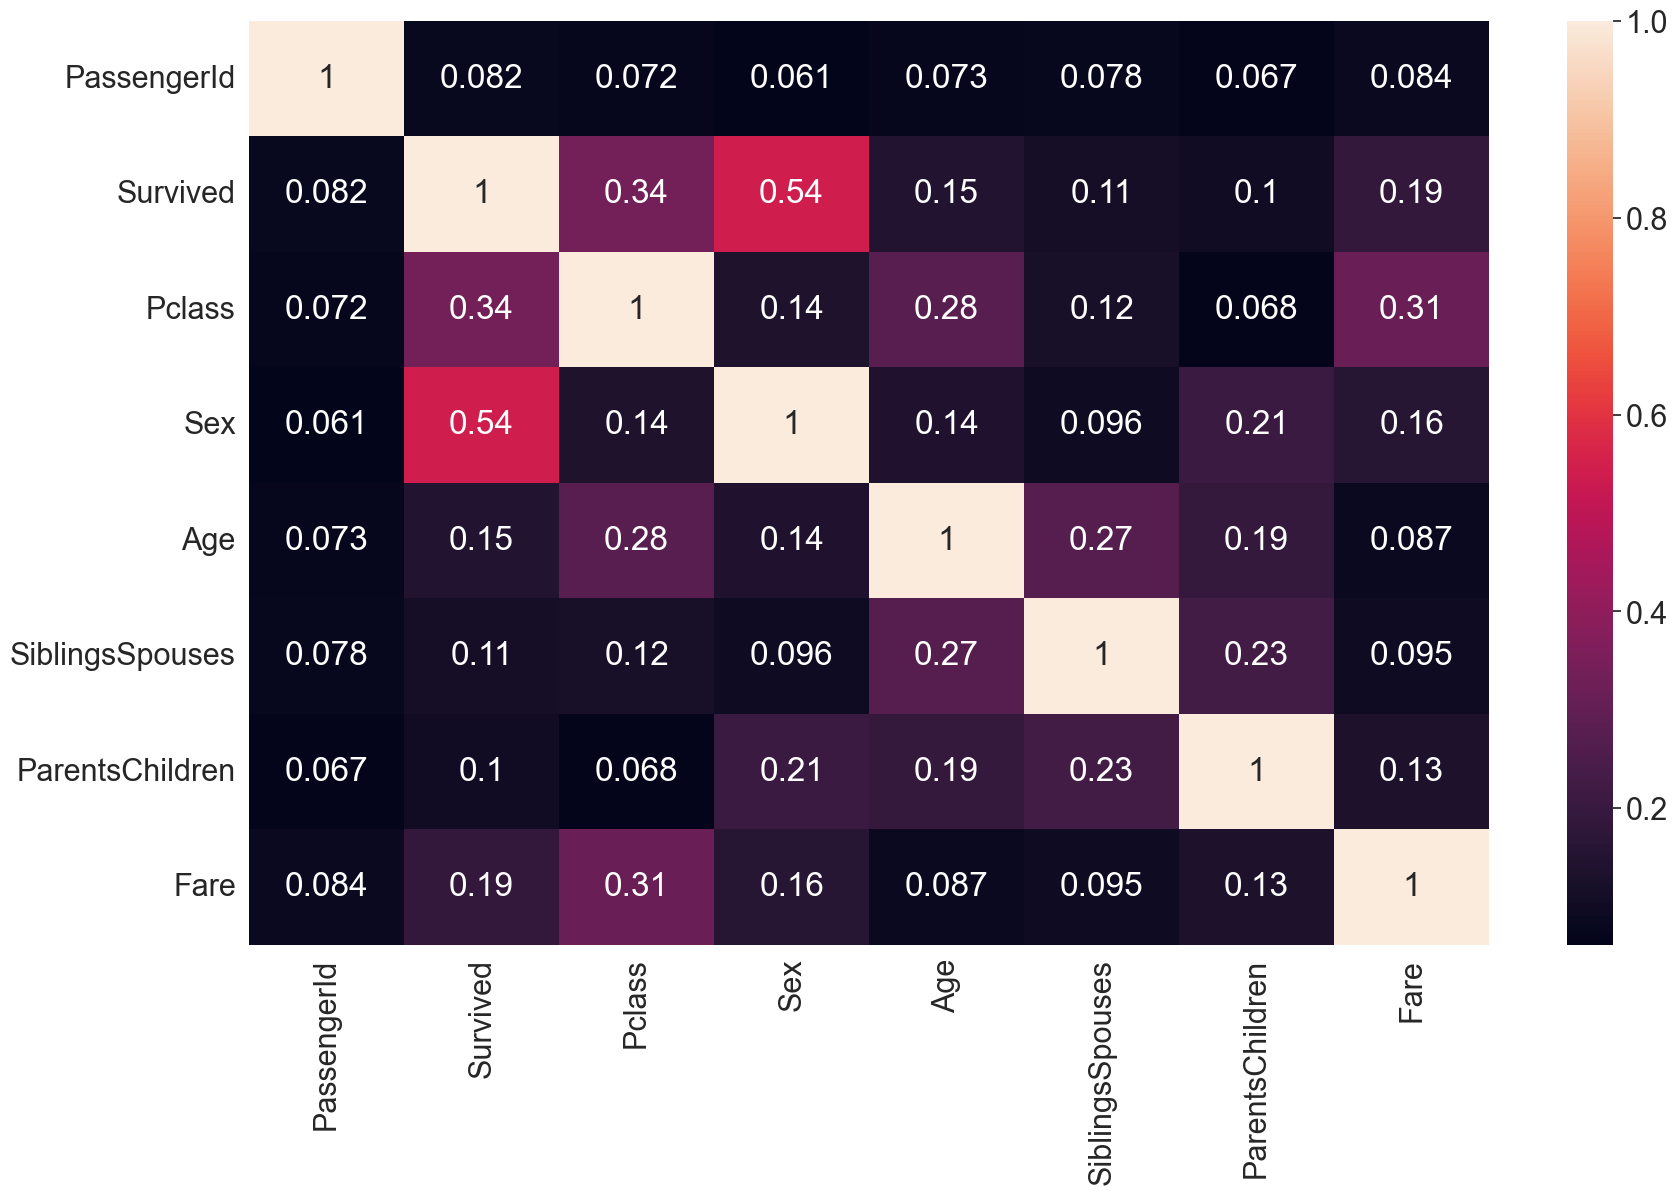

In [14]:
corr = NuestrasFunciones.get_cat_corr_mat(df_titanic.select_dtypes(exclude = "object"))
plt.rcParams["figure.figsize"] = (20, 12)
sns.heatmap(corr, annot=True)

# Se busca qué hacer con Ticket

# Personas con el mismo Ticket deben estar acompañados

In [15]:
x = df_titanic['Ticket'].apply(lambda x: x.split(" "))
df_titanic["PostTicket"] = [i[1] if len(i) == 2 else i[0] for i in x]

df_titanic.Ticket = df_titanic.Ticket.apply(lambda x: x.replace(",","").replace(".","").replace("/","").upper())


#String operations para unir diferentes PreTickets que parecen ser los mismos, eliminar comas, puntos y upper por SCPARIS
#Pudiese seguir uniendo parecidas pero sería por adivinanza

In [16]:
### Hay más agrupación en la segunda parte del ticket que en el ticket entero.
### Vale la pena buscar en post ticket la cantidad de acompañantes.

### Testear con Ticket y Post ticket en pipeline y ver Cuál da mejor resultado en Cross-validation.

In [17]:
def cant_mismo_ticket(tick,ser):
    lista = []
    val_counts = ser.value_counts()
    valor = val_counts[tick] -1
    return valor

df_titanic["Cant_PersonasMismoTicket"] = df_titanic.Ticket.apply(lambda x: cant_mismo_ticket(x,df_titanic.Ticket))
valor_cramer = NuestrasFunciones.cramers_v(df_titanic.Cant_PersonasMismoTicket,df_titanic.Survived)

array_con_postTicket = df_titanic.PostTicket.apply(lambda x: cant_mismo_ticket(x,df_titanic.PostTicket))
valor_cramer_con_postTicket = NuestrasFunciones.cramers_v(array_con_postTicket,df_titanic.Survived)

print(f"La variable creada que muestra cantidad de acompañantes tiene un valor de V de Cramer con la objetivo de: {valor_cramer}")
print(f"Valor de V de Cramer si asociamos por post-ticket: {valor_cramer_con_postTicket}")


La variable creada que muestra cantidad de acompañantes tiene un valor de V de Cramer con la objetivo de: 0.22866234689920364
Valor de V de Cramer si asociamos por post-ticket: 0.11275719863489767


### Intentando la misma columna buscando iguales en sólo PostTicket da un valor de asociación de cramer mucho peor. Haré igualmente check en cross validation para estar seguro de no estar sobre ajustando al training.

# Qué son los tickets con cosas antes??

### - No hay suficientes observaciones como para hacer one hot enconding de cada posible PreTicket.

### Dejo comentadas unas métricas con V de Cramer catastrófica:

In [18]:
#Primero investigo si la diferencia radica en desconocido o no, malos resultados.
#df_investigacion1.PreTicket = df_titanic.PreTicket.apply(lambda x: 0 if x == "desconocido" else 1)

#Segundo investigo si la diferencia radica en el len del PreTicket, malos resultados.
#df_investigacion1.PreTicket = df_titanic.PreTicket.apply(lambda x: len(x) if x != "desc" else 0)

#Tercero investigo efecto sólo de tickets más vistos, malos resultados.
#lista_investigacion1 = df_investigacion1.PreTicket.value_counts().sort_values(ascending = False)[0:7].index
#df_investigacion1.loc[:,"PreTicket"] = df_investigacion1.PreTicket.apply(lambda x: x if x in lista_investigacion1 else None).copy()

In [36]:
#Analizo el porcentaje salvado de cada PreTicket.
x = df_titanic['Ticket'].apply(lambda x: x.split(" "))
df_titanic["PreTicket"] = [i[0] if len(i) == 2 else "desconocido" for i in x]


df_titanic.PreTicket = df_titanic.PreTicket.apply(lambda x: x.replace(",","").replace(".","").replace("/","").upper())
df_titanic.PreTicket = df_titanic.PreTicket.apply(lambda x: x[0] if x[0].lower() != "s" else x[0:2])
#df_titanic.PreTicket = df_titanic.PreTicket.apply(lambda x: x if x in ["SC","SO"] else x[0])
df_titanic.PreTicket = df_titanic.PreTicket.apply(lambda x: x if x== "SO" else x[0])

df_investigacion1 = df_titanic[["PreTicket","Survived"]]

df_investigacion1 = df_investigacion1.groupby(["PreTicket"], as_index = False).agg(["mean","count"])#.sort_index().plot.barh()
df_investigacion1.columns = list(map("".join, df_investigacion1.columns.values))
df_investigacion1.reset_index(inplace = True)
#Debo hacer algo con las que tienen una, dos tres observaciones.

/var/folders/np/h92s49gs6_76jw73d98bk14m0000gn/T/ipykernel_9858/2404499602.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_investigacion1['PreTicket'], rotation=360, ha='right')


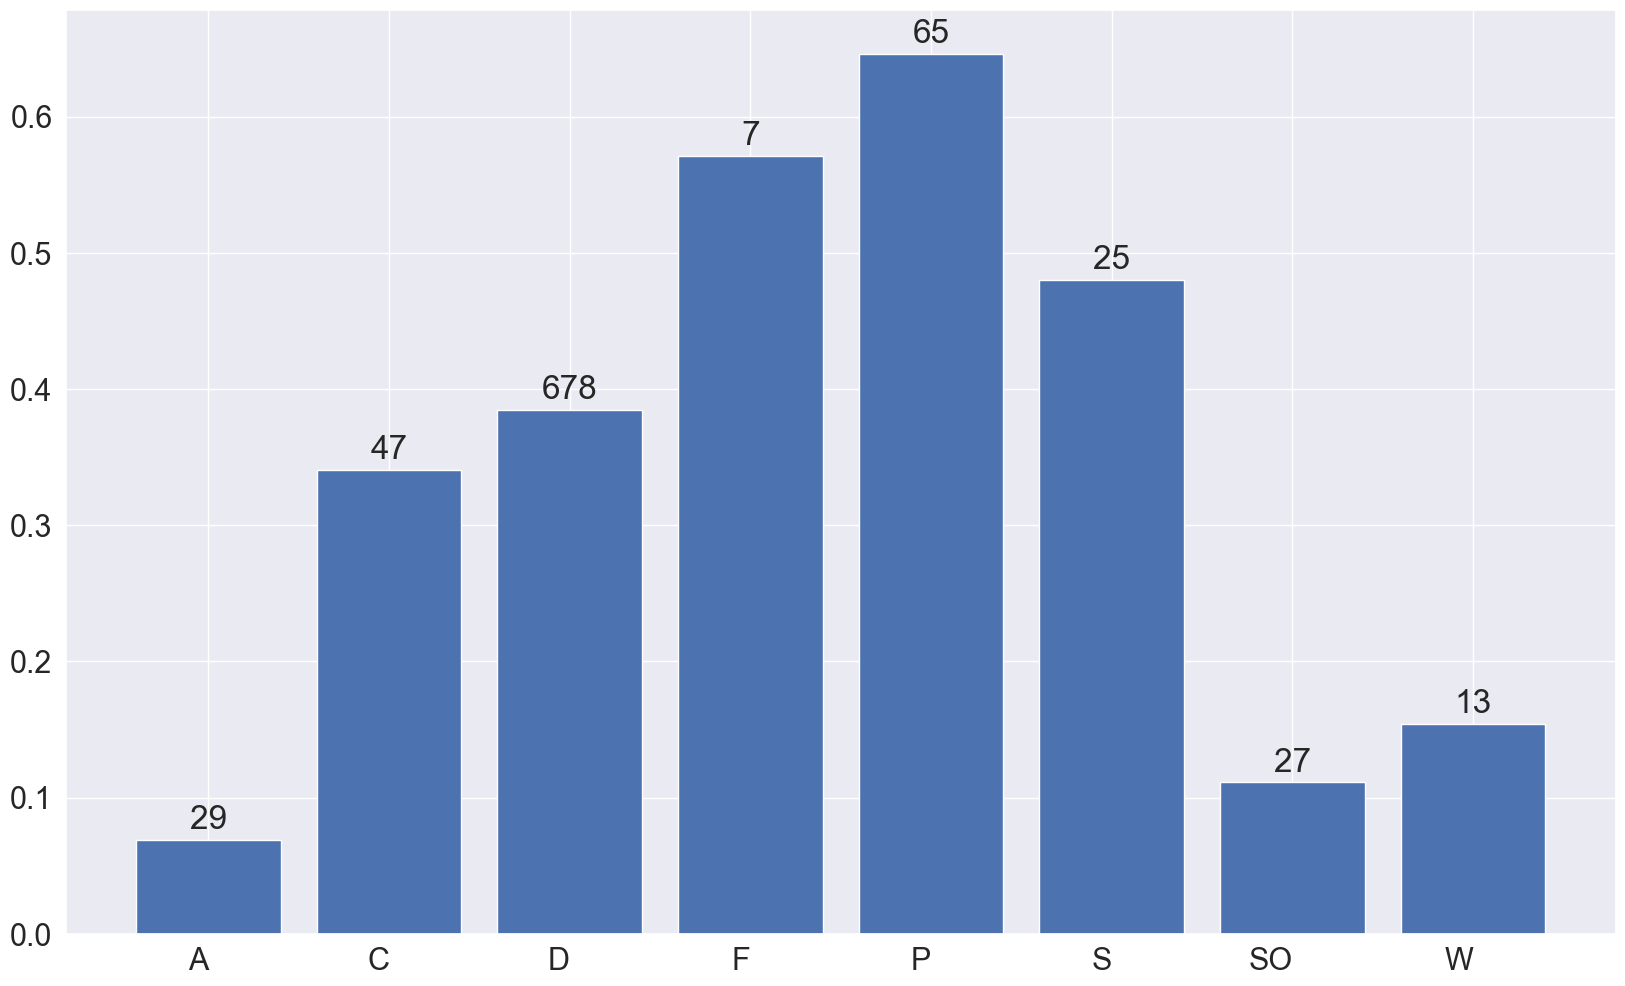

In [39]:
fig, ax = plt.subplots()
bars = ax.bar(df_investigacion1['PreTicket'], df_investigacion1['Survivedmean'])

for bar,count in zip(bars.patches, df_investigacion1.Survivedcount):
    
        height = bar.get_height()
        ax.annotate(f'{count}', xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),  # 3 points vertical offset for better readability
        textcoords='offset points',
        ha='center', va='bottom')
 
ax.set_xticklabels(df_investigacion1['PreTicket'], rotation=360, ha='right')
 
# Finally showing the plot
plt.show()

### Me gusta esta distribución, parece que la primera letra del pre-ticket dice mucho acerca de si la persona sobrevive o no. El problema vino con las S que tienen una distribución un tanto similar, al final me decanto por separar las entre S y SO.

### - Propuestas Nueva col a ser testeadas en cross validation:

### 1) % salvados con esa letra de preticket.

### 2) % salvados con esa letra de preticket. ponderado por observaciones presentes con ese PreTicket:
### [(count del preticket/total observaciones)/(salvados de ese preticket/no salvados de ese preticket)]
### Trae problemas al hacer demasiado más significante desconocido.

## Pensándolo bien no debe ser bueno crear una variable que sea combinación lineal de la objetivo, probablemente traiga problemas, será mejor ordenar las categorías con números de peor a mejor.

### - No sé si las operaciones de string están eliminando información importante.

### En el pipeline final se intentará con algunas, con todas y sin operaciones, la que tenga mejor score en validación cruzada se quedará.

In [300]:
df_investigacion1["Survived_Ponderado"] = (df_investigacion1.Survivedcount/df_titanic.shape[0])*df_investigacion1.Survivedmean
#Propuesta1 = df_investigacion1[["PreTicket","Survivedmean"]]
#Propuesta2 = df_investigacion1[["PreTicket","Survived_Ponderado"]]
def asignarango(tick):
    if tick == "A":
        return 1
    elif tick == "SO":
        return 2
    elif tick == "W":
        return 3
    elif tick == "C":
        return 4
    elif tick == "D":
        return 5
    elif tick == "S":
        return 6
    elif tick == "F":
        return 7
    elif tick == "P":
        return 8

df_investigacion1["Ticket_Rank"] = df_investigacion1.PreTicket.apply(lambda x: asignarango(x))
df_investigacion1.sort_values(by = "Survivedmean")

,PreTicket,Survivedmean,Survivedcount,Survived_Ponderado,Ticket_Rank
0,A,0.068966,29,0.002245,1
6,SO,0.111111,27,0.003367,2
7,W,0.153846,13,0.002245,3
1,C,0.340426,47,0.017957,4
2,D,0.384956,678,0.292929,5
5,S,0.480000,25,0.013468,6
3,F,0.571429,7,0.004489,7
4,P,0.646154,65,0.047138,8


In [303]:
def metrica_preticket(Ticket, df, metrica):
    return df.loc[df["PreTicket"] == Ticket,metrica].values[0]

df_titanic["Porcentaje_PreTicket"] = df_titanic.PreTicket.apply(lambda x: metrica_preticket(x,df_investigacion1,"Survivedmean"))
df_titanic["PorcentajePonderado_PreTicket"] = df_titanic.PreTicket.apply(lambda x: metrica_preticket(x,df_investigacion1,"Survived_Ponderado"))
df_titanic["Ticket_Rank"] = df_titanic.PreTicket.apply(lambda x: metrica_preticket(x,df_investigacion1,"Ticket_Rank"))


cramer1 = NuestrasFunciones.cramers_v(df_titanic.Porcentaje_PreTicket,df_titanic.Survived)
cramer2 = NuestrasFunciones.cramers_v(df_titanic.PorcentajePonderado_PreTicket,df_titanic.Survived)
cramer3 = NuestrasFunciones.cramers_v(df_titanic.Ticket_Rank,df_titanic.Survived)

print(f"La variable sin ponderar tiene un valor de V de Cramer con la objetivo de: {cramer1}")
print(f"La variable ponderada tiene un lamentable valor de V de Cramer con la objetivo de: {cramer2}")
print(f"La variable con el rank tiene un valor de V de Cramer con la objetivo de: {cramer3}")

df_titanic.drop(["PorcentajePonderado_PreTicket","Porcentaje_PreTicket"], axis = 1,inplace = True)



La variable sin ponderar tiene un valor de V de Cramer con la objetivo de: 0.22236231686576632
La variable ponderada tiene un lamentable valor de V de Cramer con la objetivo de: 0.004099207464745925
La variable con el rank tiene un valor de V de Cramer con la objetivo de: 0.2228310717362426


## Al final nos evitamos problemas estadísticos y mejoramos la V de Cramer utilizando el rango del ticket en vez de una combinación lineal con la objetivo.

# Qué hacer con Name?

### Inspiración para hacer el dataset fueron profesores.

### Recuerdo que uno dijo que los apellidos funcionaban para ver idioma que habla el sujeto. Pero revisemos qué más se puede sacar de ellos.

In [176]:
#Algunos nombres tienen otro nombre entre paréntesis, hagamos búsqueda.
# ej: Cumings, Mrs. John Bradley (Florence Briggs Thayer)
j = 0
for i in df_titanic.Name:
    j += 1
    if "Borland" in i: 
        print(i,j)
    

print(df_titanic.Ticket[551],df_titanic.Ticket[582],df_titanic.Ticket[699])
print("--------------------------------")
z = 0
for i in df_titanic.Name:
    z += 1
    if "Bourke" in i: 
        print(i,z)
        

print(df_titanic.Ticket[189],df_titanic.Ticket[594],df_titanic.Ticket[658])

Thayer, Mr. John Borland Jr 551
Thayer, Mrs. John Borland (Marian Longstreth Morris) 582
Thayer, Mr. John Borland 699
244358 28403 348121
--------------------------------
Bourke, Mr. John 189
Bourke, Miss. Mary 594
Bourke, Mrs. John (Catherine) 658
349247 SCAH 29037 29751


#### Estos vienen definitivamente juntos y no tienen el mismo ticket number, mismo apellido nos dará buena info.

In [203]:
#Creo columna apellido que no será útil en el modelo final, pero si para este análisis
x = df_titanic.Name.apply(lambda x: x.split(","))
df_titanic["Apellido"] = df_titanic.Name.apply(lambda x: x.split(",")[0])

#### Cantidad mismo apellido es: <frecuencia de tu apellido -1> Porque se define como cantidad de personas con mismo apellido que tú excluyendo al analizado.

In [283]:
def mismo_apellido(ape, ser):
    valores = ser.value_counts()
    return valores[ape] - 1

df_titanic["Cantidad_MismoApellido"] = df_titanic["Apellido"].apply(lambda x: mismo_apellido(x,df_titanic.Apellido))
cramer = NuestrasFunciones.cramers_v(df_titanic["Cantidad_MismoApellido"],df_titanic["Survived"])
print(f"La variable cantidad de personas con tu mismo apellido tiene un valor de V de Cramer con la objetivo de: {cramer}")

La variable cantidad de personas con tu mismo apellido tiene un valor de V de Cramer con la objetivo de: 0.10948632209863142


In [ ]:
w = 0
for i in df_titanic.Name:
    w += 1
    if "(" in i:
        if df_titanic.SiblingsSpouses[w] == 0 and df_titanic.ParentsChildren[w] == 0 :
            #print(i)
           #print("--------------------------------")
            pass

#Hay una lady y una contesa

#### Los nombres en () son en su mayoría los nombres de las Mrs. el nombre principal es el de su esposo

In [224]:
df_titanic["Titulo"] = df_titanic.Name.apply(lambda x: x.split(",")[1].split(".")[0].replace(" ",""))
df_titanic["Titulo"].value_counts()

Mr             517
Miss           182
Mrs            125
Master          40
Dr               7
Rev              6
Mlle             2
Major            2
Col              2
theCountess      1
Capt             1
Ms               1
Sir              1
Lady             1
Mme              1
Don              1
Jonkheer         1
Name: Titulo, dtype: int64

In [207]:
df_investigacion2 = df_titanic[["Titulo","Survived"]]

df_investigacion2 = df_investigacion2.groupby(["Titulo"], as_index = False).agg(["mean","count"])#.sort_index().plot.barh()
df_investigacion2.columns = list(map("".join, df_investigacion2.columns.values))
df_investigacion2.reset_index(inplace = True)

/var/folders/np/h92s49gs6_76jw73d98bk14m0000gn/T/ipykernel_9858/2732409440.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_investigacion2['Titulo'], rotation=90, ha='right')


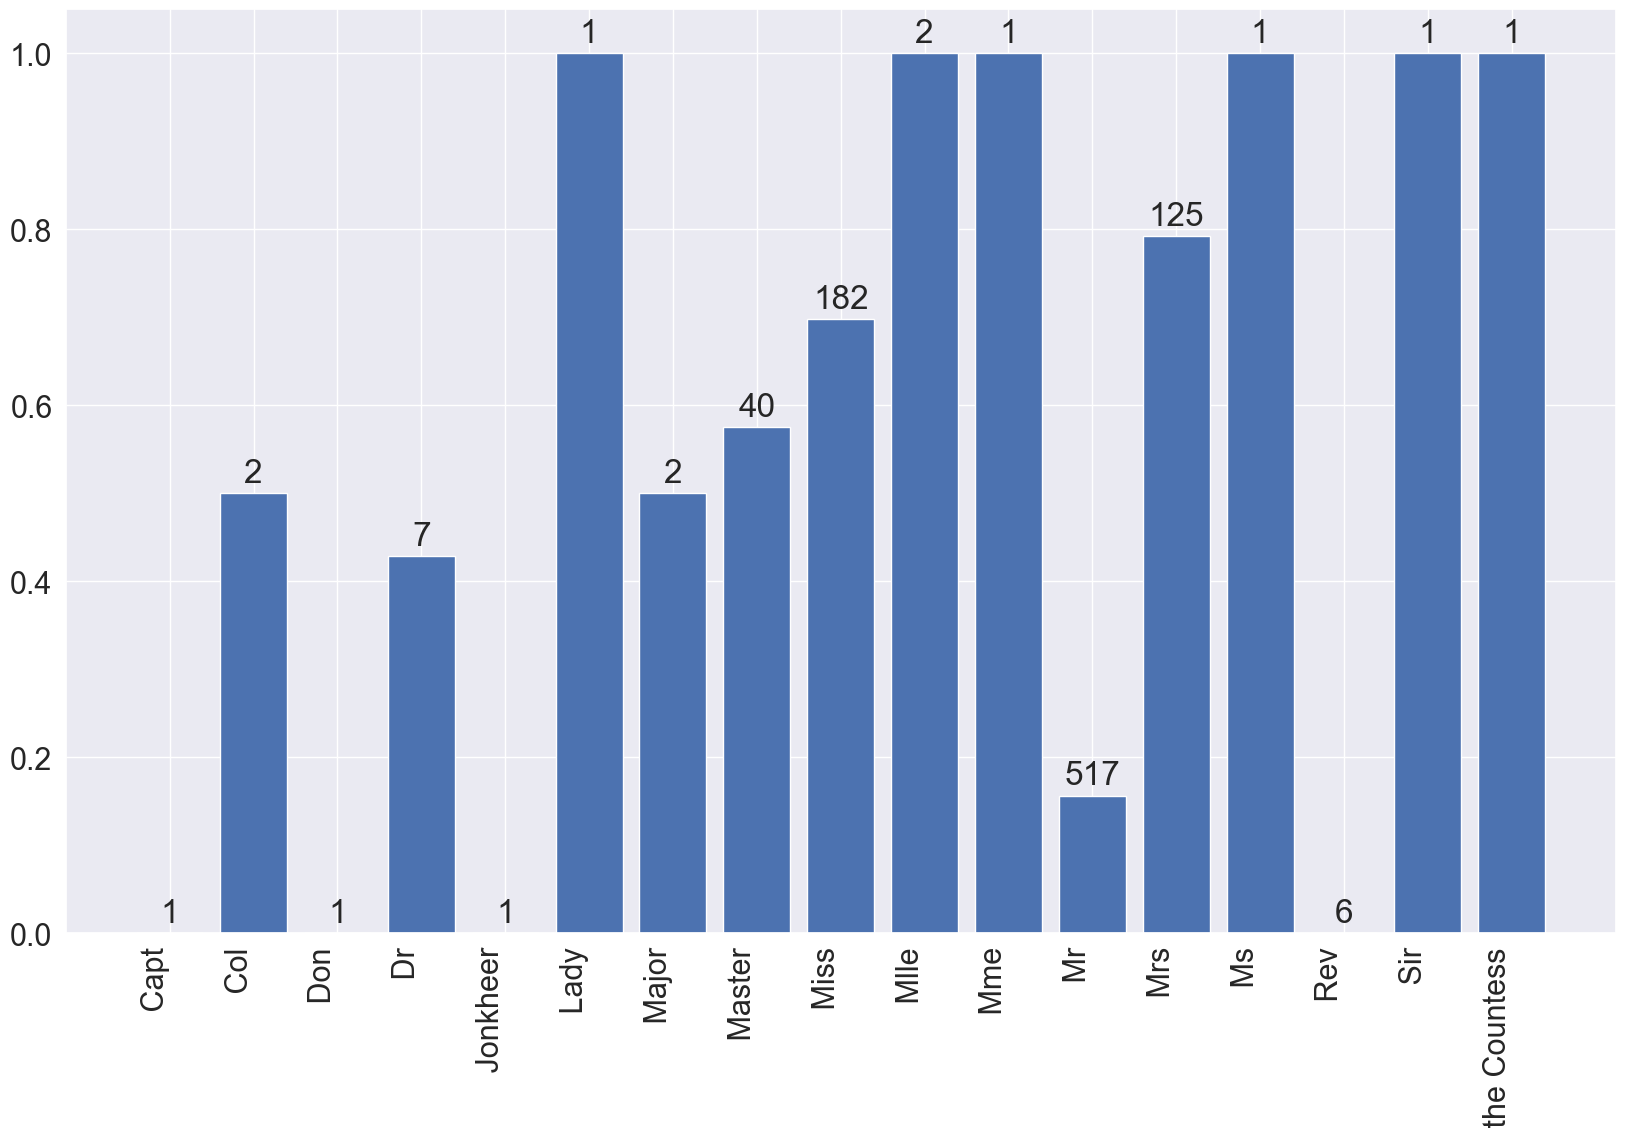

In [211]:
fig, ax = plt.subplots()
bars = ax.bar(df_investigacion2['Titulo'], df_investigacion2['Survivedmean'])

for bar,count in zip(bars.patches, df_investigacion2.Survivedcount):
    
        height = bar.get_height()
        ax.annotate(f'{count}', xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),  # 3 points vertical offset for better readability
        textcoords='offset points',
        ha='center', va='bottom')
 
ax.set_xticklabels(df_investigacion2['Titulo'], rotation=90, ha='right')
 
# Finally showing the plot
plt.show()

In [240]:
df_titanic.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age',
       'SiblingsSpouses', 'ParentsChildren', 'Ticket', 'Fare', 'Cabin',
       'Embarked', 'PostTicket', 'Cant_PersonasMismoTicket', 'PreTicket',
       'Porcentaje_PreTicket', 'Apellido', 'Cantidad_MismoApellido', 'Titulo'],
      dtype='object')

#### Tip de profesor invitado de Vodafone: los Reverendos se sacrifican por los demás.

#### Gracias Wikipedia! "Master is an English honorific for boys and young men" ¿Pero por qué sobreviven tan poco si women and children first?

#### Las Miss son probablemente hijas o mistresses.

<Axes: >

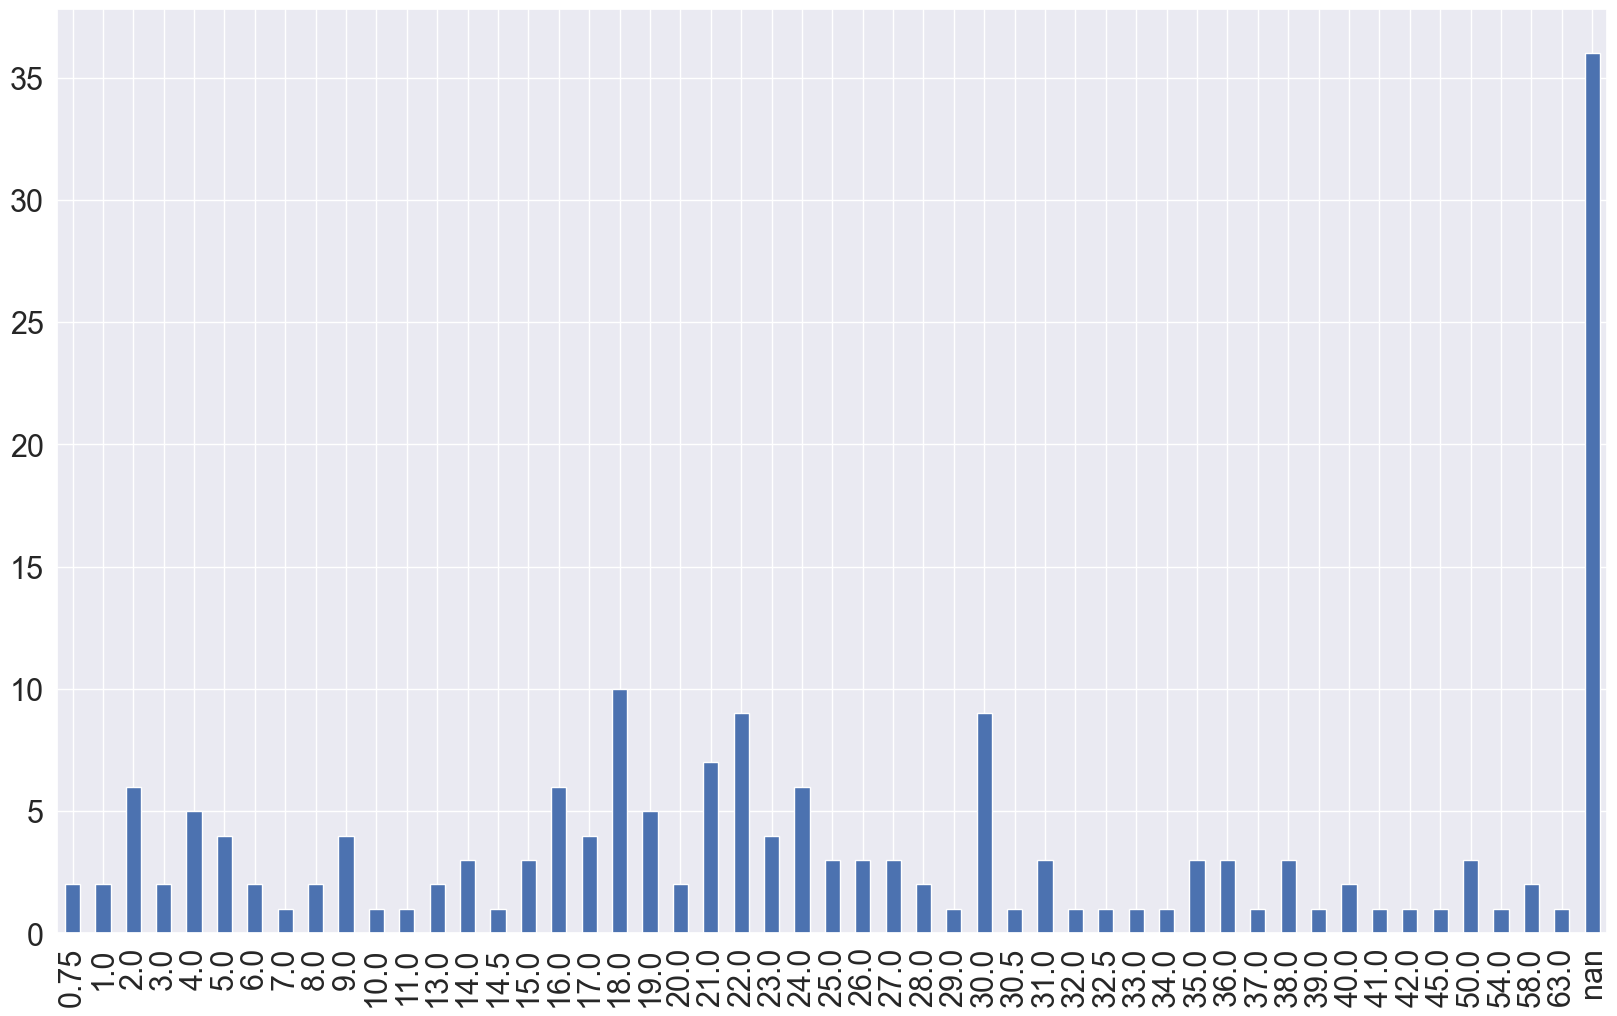

In [272]:
investiga_miss1 = df_titanic[["Titulo","Age","SiblingsSpouses","ParentsChildren"]]
investiga_miss1 = investiga_miss1.loc[investiga_miss1["Titulo"] == "Miss"]
investiga_missings.Age.value_counts(dropna = False).sort_index().plot.bar()

#### Demasiados Nas (cuya distribución desconocemos), como para hacer un análisis fidedigno de esta manera.

In [291]:
#Si es Mistress tendrá 0 ParentChildren, 0 SpouseSibling!!!!
investiga_miss2 = df_titanic[["Titulo","Age","SiblingsSpouses","ParentsChildren","Cantidad_MismoApellido"]]
investiga_miss2 = investiga_miss2.loc[investiga_miss2["Titulo"] == "Miss"]
investiga_miss2 = investiga_miss2.loc[(investiga_miss2["Cantidad_MismoApellido"] != 0)]
#(investiga_miss2["SiblingsSpouses"] == 0) &
#&(investiga_miss2["Cantidad_MismoApellido"] == 0)
#(investiga_miss2["ParentsChildren"] == 0)
investiga_miss2.shape

(80, 5)

# Queda mucho por hacer con los títulos y la métrica creada por nosostos "Cantidad_MismoApellido"

# Qué hacer con Age?

### Variable con 0.15 de V de Cramer y muchos missings.

Cont


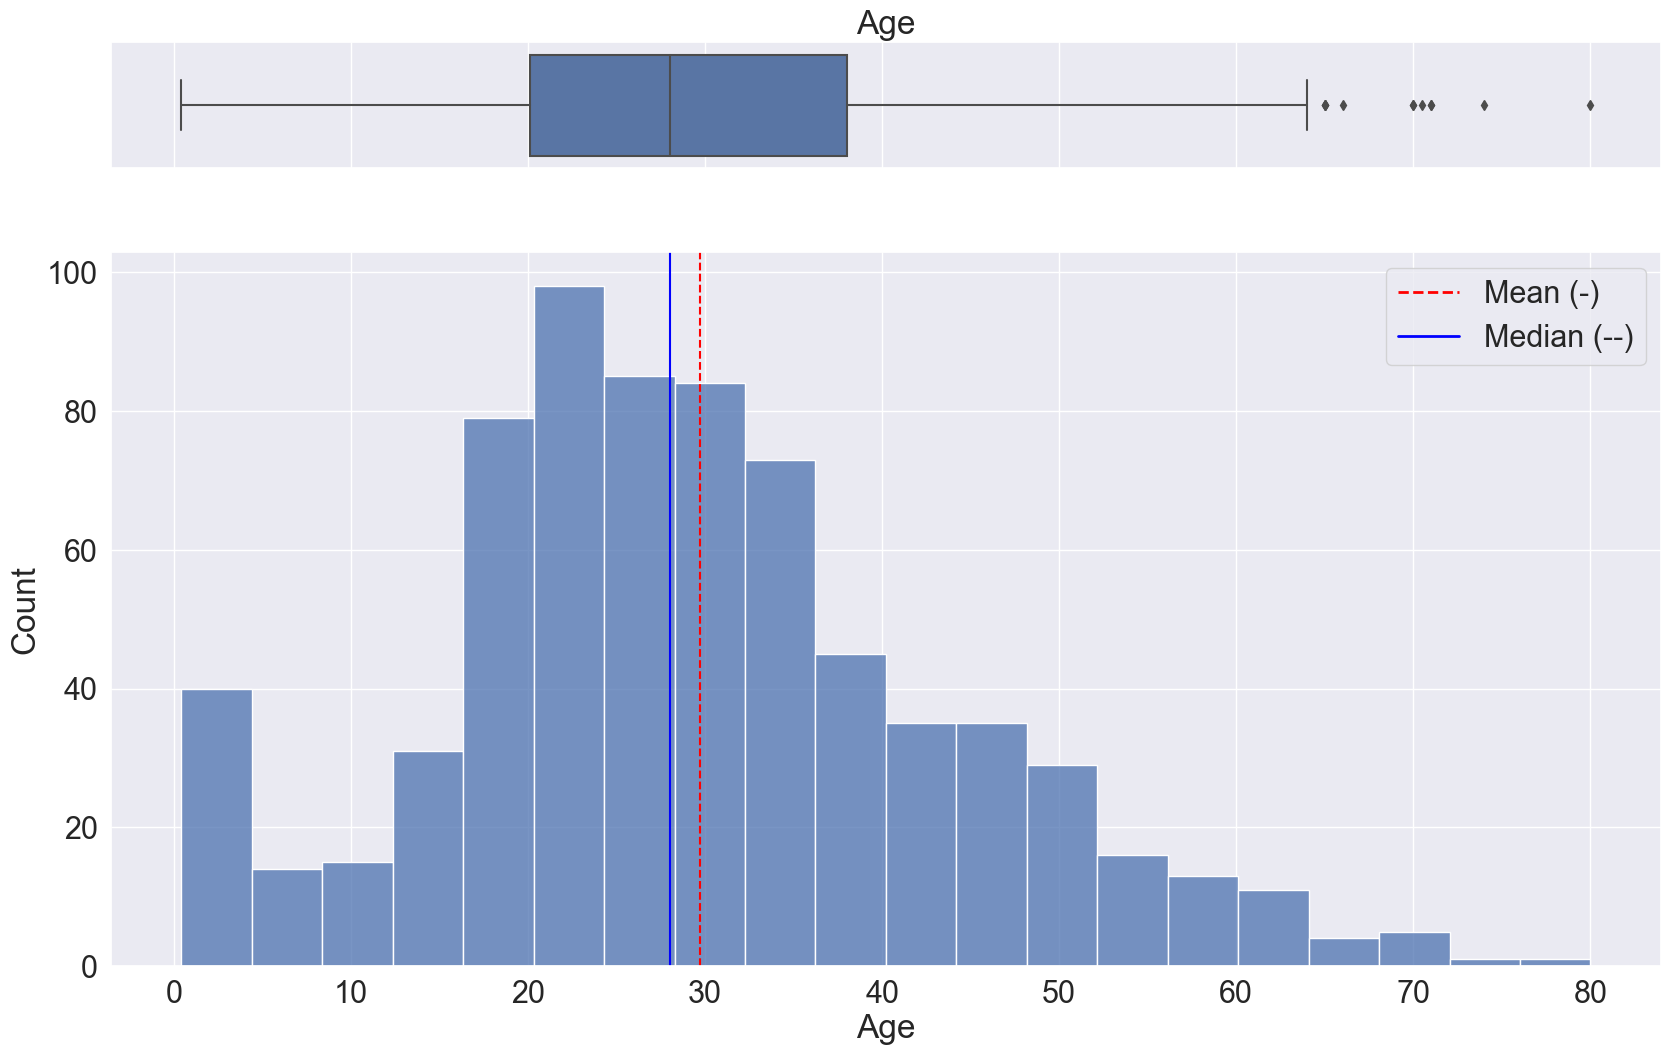

In [79]:
NuestrasFunciones.plot(df_titanic.Age)

In [80]:
df_investigacion3 = df_titanic[["Age","ParentsChildren","SiblingsSpouses","Survived"]]
#si no tiene ni SiblingsSpouses: puede ser only child o padre soltero o persona sin hijos soltera
#si no tiene ParentsChildren: es o niño que viaja solo o persona adulta sin hijos
#Niño sin hijos tuviese ParentsChildren = 0, Cabin única

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age',
       'SiblingsSpouses', 'ParentsChildren', 'Ticket', 'Fare', 'Cabin',
       'Embarked', 'PostTicket', 'Cant_PersonasMismoTicket', 'PreTicket',
       'Porcentaje_PreTicket'],
      dtype='object')

In [234]:
df_titanic.isna().sum()

PassengerId                   0
Survived                      0
Pclass                        0
Name                          0
Sex                           0
Age                         177
SiblingsSpouses               0
ParentsChildren               0
Ticket                        0
Fare                          0
Cabin                       687
Embarked                      2
PostTicket                    0
Cant_PersonasMismoTicket      0
PreTicket                     0
Porcentaje_PreTicket          0
Apellido                      0
Cantidad_MismoApellido        0
Titulo                        0
dtype: int64

# Niños que viajan solos

In [ ]:
###